In [1]:
import numpy as np
from scipy.integrate import odeint
import sir_mcmc_utils as utils
import pandas
import matplotlib.pyplot as plt

In [7]:
infected = np.array([36,106,283,495,564,459,495,495,283,211,69,35])
days = np.array([0,1,2,3,4,5,6,7,8,9,10,11])

In [26]:
def modelo(u,p,t):
  Sh, Ih, Ah, Iv = u
  Nv, p, βh, βv, γ, δh, μv, σ = p
  b = 1.
  du1 =  0.0011*5870 - (βh*b)/5870*Sh*Iv - 0.0011*Sh #S_h'
  du2 =  (βh*b)/5870*Sh*Iv - (0.0011+γ)*Ih + δh*Ah #I_h'
  du3 =  p*γ*Ih - (0.0011+δh)*Ah #A_h'
  du4 =  (βv*b)/5870*(Nv-Iv)*(Ih+σ*Ah) - μv*Iv #I_v'
  return np.array([du1,du2,du3,du4])


In [57]:

Nv = 32285.

p = 0.3
beta_h = 2.
beta_v = 1.1
gamma = 4.
delta_h = 1.
mu_v = 3.
sigma = 0.5
#pars = np.array([ Nv, p, beta_h, beta_v, gamma, delta_h, mu_v, sigma])

u0 = [5834, 36, 0, 0] #S_h(0), I_h(0), A_h(0), I_v(0)


sigma_1 = .01;
sigma_2 = 5.


like=0.0000000001
loglike=np.log(like)
Number_of_steeps = 100000
Burn_in_Time = 1000
mcmc_file_name = "mcmc_lupita.dat"

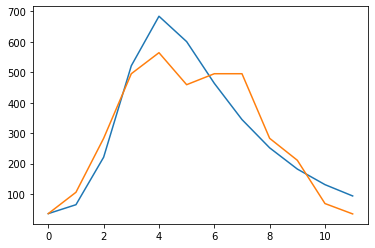

In [52]:
#definir el modelo con los parametros elegidos
def model(y,t):
	return modelo(y,pars,t)
	#resolver el modelo
model_prediction = odeint(model, u0, days)

plt.plot(days,model_prediction[:,1])
plt.plot(days,infected)
plt.show()

In [58]:
file_h = open(mcmc_file_name,"w+",buffering=1)
file_h.write('Nv,p,beta_h,beta_v,gamma,delta_h,mu_v,sigma,log_likelihood\n')

for i in range(Number_of_steeps):
	#verificar que sea positivo
	Nv_try = abs(np.random.normal(Nv, sigma_2))
	pars_try = abs(pars + np.random.normal(0,sigma_1,size=8))
	#definir el modelo con los parametros elegidos
	def model(y,t):
		return modelo(y,pars_try,t)
		
	#resolver el modelo
	
	model_prediction = odeint(model, u0, days)
	
	#calcular likelihood
	loglike_try = utils.PoissonLikelihood(infected,model_prediction[:,1])
	
	#calcular numero aleatorio para comparar con la division de la anterior
	if (loglike_try < loglike):
		random = np.random.uniform(0.0,1.0)
		accepted = np.exp(loglike_try - loglike)
	else:
		accepted = 1.
		
	if ( random < accepted):
		pars = pars_try
		loglike = loglike_try

	if(i>Burn_in_Time):
		line = '{} , {} , {} , {} , {} , {} , {} , {} , {} \n'.format(pars[0],pars[1],pars[2],pars[3],pars[4],pars[5],pars[6],pars[7],loglike)
		file_h.write(line)


file_h.close()

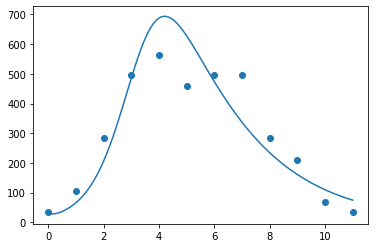

In [55]:
#definir el modelo con los parametros elegidos
def model(y,t):
	return modelo(y,pars,t)

time = np.linspace(0,11,100)
model_prediction = odeint(model, u0, time)
plt.plot(time,model_prediction[:,1])

plt.scatter(days,infected)
plt.show()

In [59]:
MCMC = pandas.read_csv(mcmc_file_name)
MCMC.head()

,Nv,p,beta_h,beta_v,gamma,delta_h,mu_v,sigma,log_likelihood
0,32284.095314,0.555656,2.078551,2.281159,3.481099,1.120958,5.342092,0.008837,17307.780575
1,32284.095314,0.555656,2.078551,2.281159,3.481099,1.120958,5.342092,0.008837,17307.780575
2,32284.095314,0.555656,2.078551,2.281159,3.481099,1.120958,5.342092,0.008837,17307.780575
3,32284.095314,0.555656,2.078551,2.281159,3.481099,1.120958,5.342092,0.008837,17307.780575
4,32284.095314,0.555656,2.078551,2.281159,3.481099,1.120958,5.342092,0.008837,17307.780575


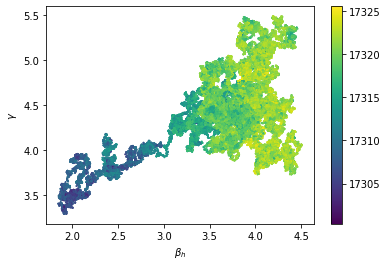

In [60]:
plt.scatter(x=MCMC.beta_h,y=MCMC.gamma,c=MCMC.log_likelihood,s=1)
plt.xlabel(r'$\beta_h$')
plt.ylabel(r'$\gamma$')
plt.colorbar()
#plt.xlim([0.3328,0.3336])
#plt.ylim([0.4994,0.50025])
#plt.xlim([0.0,1.])
#plt.ylim([0.0,1.])
plt.show()

In [62]:
df = MCMC.drop_duplicates()
print(df.shape)
max_like = df['log_likelihood'].max()

best_parameters = df[df['log_likelihood']==max_like]
#gamma_best = best_parameters['gamma'].values[0]
#beta_best = best_parameters['beta'].values[0]
#print(gamma_best)
#print(beta_best)
print(best_parameters)
MCMC.quantile([0.025,0.975])

(36027, 9)
                 Nv         p    beta_h    beta_v     gamma   delta_h  \
55257  32285.229348  0.683858  4.061773  2.315037  4.846726  1.673839   

            mu_v     sigma  log_likelihood  
55257  10.273127  0.000228    17325.531852  


,Nv,p,beta_h,beta_v,gamma,delta_h,mu_v,sigma,log_likelihood
0.025,32283.953787,0.586022,2.121798,1.785282,3.694521,1.215111,5.318361,0.000360,17307.931803
0.975,32286.461633,0.709644,4.370323,2.344051,5.319290,1.798907,10.008173,0.050746,17324.034774
